# JAX random number design

In [1]:
import matplotlib.pyplot as plt
import math
import time

## Pseudo random numbers and generators
Scientific computing doesn't use purely random numbers, only pseudo random numbers (PRN) -- generated values that appear random.
The main reasons are:
- ease of use - generating PRNs in software is fast
- reproducability - using the same PRN sequence will give the same results.

A sequence of PRNs is generated by a PRN generator (RNG). These are deterministic sequences which start from some _seed value_.

A simple (but poor) RNG is the _linear congruential generator_:
$$
X_i = aX_{i-1}+c\quad (\text{mod } m)
$$

Setting $a = 1103515245$, $c=12345$ and $m=32768$ gives GCC's implementaion of `rand` for the C programming language ([caveat: never use `C`'s `rand`](https://channel9.msdn.com/Events/GoingNative/2013/rand-Considered-Harmful))

In [2]:
class LCG():
    def __init__(self, seed=1, a=1103515245, c=12345, m=32768):
        self.state = seed;
        self.a = a
        self.c = c
        self.m = m
    def seed(self, seed):
        self.state = seed
    def __call__(self):
        self.state = self.state * self.a + self.c;
        self.state %= self.m
        return self.state;
   
rand = LCG();

In [3]:
rand()

32422

In [4]:
x = [rand() for i in range(10000)]

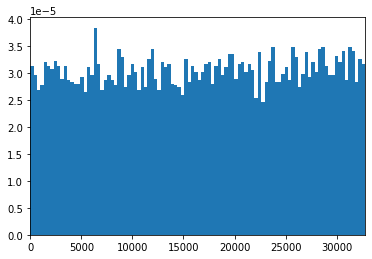

In [5]:
plt.hist(x, density=True, bins=100)
plt.xlim(0, rand.m)
plt.show()

**A generator is deterministic given the seed value**

In [6]:
rand0 = LCG(seed = 42)
x = [rand0() for i in range(10000)]

rand1 = LCG(seed = 2909)
y = [rand1() for i in range(10000)]

x == y # False -- different seeds

False

In [7]:
rand0 = LCG(seed = 42)
x = [rand0() for i in range(10000)]

rand1 = LCG(seed = 42)
y = [rand1() for i in range(10000)]

x == y # True -- same seeds

True

### Critique
- Aside from the LCG being a mathematically bad, is `LCG` user friendly? 
- What problems does `LCG` have if we want to write some distribution samplers?

The main issue (which goes for `numpy`, `R`, `C++11` and lots of other programming languages) is: **_Global State is Bad_**&trade;

In [8]:
import numpy as np

def runif(n, a=0, b=1):
    "ContinuousUniform(a, b) distribution"
    x = np.array([rand()/rand.m for _ in range(n)])
    return (b-a) * x + a

runif(10, 0, 10)

array([0.84686279, 6.23168945, 7.39654541, 4.20959473, 9.80072021,
       2.82714844, 4.42657471, 6.10778809, 9.82879639, 6.51245117])

In [9]:
def foo(n):
    "A function that consumes random numbers"
    return np.sum(runif(n))
    
# Consider this as a global variable -- i.e. its initialised by python when you start a python process
rand = LCG(0)
[foo(5) for _ in range(10)]

[1.263397216796875,
 2.9014892578125,
 2.137603759765625,
 2.60308837890625,
 1.810150146484375,
 3.00341796875,
 2.105255126953125,
 2.37982177734375,
 2.940887451171875,
 2.7283935546875]

- What happens if we go parallelise a computation that calls `runif` accross a number of threads?

Either:
1. we lose reproducibility - which thread calls `rand` first is indeterminite!
2. we lose parallelism - need to synchronise the calls to `rand` accross threads!

In [10]:
## Don't do this low-level stuff in Python!
from multiprocessing import Pool

def bar(n, np=10):
    results = []
    with Pool(np) as  p:
        call = p.map_async(foo, np * [n])
        results.append(call.get())
    return results

In [11]:
rand = LCG(0) 
bar(5, 10)

[[1.263397216796875,
  1.263397216796875,
  2.9014892578125,
  2.137603759765625,
  1.263397216796875,
  1.263397216796875,
  2.9014892578125,
  1.263397216796875,
  1.263397216796875,
  1.263397216796875]]

this messes up because of a data race - each thread accesses `rand()` independently!

_note for the interested_: We can make this correct by obtaining a lock on `rand`, but this synchronises the threads (some will block waiting for access to `rand`).

## JAX RNG 
The last section highlighted a couple of problems, if we look at JAX's design notes for RNGs we find a couple more:
> We want a PRNG design that
> 1. is **expressive** in that it is convenient to use and it doesn’t constrain the user’s ability to write numerical programs with exactly the behavior that they want,
> 2. enables **reproducible** program execution in a backend-independent way,
> 3. has semantics that are **invariant to `@jit` compilation boundaries and device backends**,
> 4. enables **vectorization for generating array values** using SIMD hardware,
> 5. is **parallelizable** in that it doesn’t add sequencing constraints between random function calls that otherwise would have no data dependence,
> 6. scales to **multi-replica, multi-core, and distributed computation**,
> 7. **fits with JAX and XLA semantics** and design philosophies (which are ultimately motivated by other practical concerns).

*Note*: _parallelisable_ means running a computation in different threads, where as _vectorisation_ means taking advantage of modern computer chips which might have SIMD instructions (Single Instruction Multiple Data).

This list covers two concerns: 
- What should the API look like? (points 1,2,3,7)
- What kind of RNG can be used (points 4,5,6)

As shown in the previous section, global state RNGs can't be both reproducible and (purely) parallisable.
The order of execution also matters. (`runif(1) + runif(1)` which call is evaluated first?) This violates the ability to `@jit` a function.
The main issue is that Global/Shared state restricts parallising and coding accross "compilation boundaries" (i.e. python or compiled code using the same RNG)

# Alternative RNG desgin 1

One alternative to the global state RNG is to pass around the generator. This is a more functional-style, but now the state is part of the data of each function which also kills parallelism -- everything is sequential!

In [12]:
from collections import namedtuple 

# A state of the RNG
lcg_state = namedtuple('lcgstate', ['state', 'a','c', 'm'])

# A factory
def lcg(a=1103515245, c=12345, m=32768):
    return lcg_state(0,a,c,m)

# Methods to act on a state and return a new state **leaving the original unaltered**
def draw(state):
    s,a,c,m = state
    s = (s * a + c) % m
    return s, lcg_state(s,a,c,m)

def seed(state, seed):
    _, a, c, m = state
    return lcg_state(seed,a,c,m)

In [13]:
rand = lcg()
rand

lcgstate(state=0, a=1103515245, c=12345, m=32768)

In [14]:
draw(rand), rand

((12345, lcgstate(state=12345, a=1103515245, c=12345, m=32768)),
 lcgstate(state=0, a=1103515245, c=12345, m=32768))

In [15]:
draw(rand), draw(rand)

((12345, lcgstate(state=12345, a=1103515245, c=12345, m=32768)),
 (12345, lcgstate(state=12345, a=1103515245, c=12345, m=32768)))

In [16]:
x, rand = draw(rand)
y, rand = draw(rand)
x, y, rand

(12345, 5758, lcgstate(state=5758, a=1103515245, c=12345, m=32768))

In [17]:
def runif(rng_state, n, a=0, b=1):
    out = []
    for _ in range(n):
        x, rng_state = draw(rng_state)
        out.append((b-a) * x/getattr(rng_state, 'm') + a)
    return out, rng_state
    
rand = seed(rand, 0)
x, rand = runif(rand, 10)
x

[0.376739501953125,
 0.17572021484375,
 0.311492919921875,
 0.2200927734375,
 0.179351806640625,
 0.22296142578125,
 0.773284912109375,
 0.617919921875,
 0.355010986328125,
 0.93231201171875]

In [18]:
def rbernoulli(rng_state, n): # no global state is touched since we pass in the generator...
    x, rng_state = runif(rng_state, n)
    x = [i > 0.5 for i in x]
    return x, rng_state

coin_flips, rand = rbernoulli(rand, 10)
coin_flips

[False, True, False, False, False, True, False, False, True, True]

If we want to parallelise calls to `rbernoulli` each call must be passed the `rand` generator object:

In [19]:
def flip_coin(rng_state):
    x, rng_state = rbernoulli(rng_state, 1)
    x = "heads" if x[0] else "tails"
    return x, rng_state

def play_game(rand0):
    player_one, rand1 = flip_coin(rand0)
    player_two, rand2 = flip_coin(rand1)
    if player_one == player_two:
        print("It's a draw")
    elif player_one == "heads":
        print("Player one wins!")
    else:
        print("Player two wins!")
    return player_one, player_two, rand2


for _ in range(10):
    print(rand)
    _, _, rand = play_game(rand)

lcgstate(state=26716, a=1103515245, c=12345, m=32768)
It's a draw
lcgstate(state=15418, a=1103515245, c=12345, m=32768)
It's a draw
lcgstate(state=11848, a=1103515245, c=12345, m=32768)
It's a draw
lcgstate(state=25094, a=1103515245, c=12345, m=32768)
It's a draw
lcgstate(state=26356, a=1103515245, c=12345, m=32768)
Player one wins!
lcgstate(state=6290, a=1103515245, c=12345, m=32768)
Player two wins!
lcgstate(state=32352, a=1103515245, c=12345, m=32768)
It's a draw
lcgstate(state=11230, a=1103515245, c=12345, m=32768)
It's a draw
lcgstate(state=8332, a=1103515245, c=12345, m=32768)
It's a draw
lcgstate(state=10218, a=1103515245, c=12345, m=32768)
Player one wins!


**Note**: the design is sequential, rand has to be passed back from every function that uses random numbers.

# Alternative 2 - Parallelisable RNGs
Before diving into the RNG that JAX uses, lets think about parallelising a traditional RNG.
The essence of such a RNG is a state space $S$ and a function $f: S \rightarrow S$ used as:
$$
s_{n+1} = f(s_n)
$$
Seeding such a RNG means setting $s_0$.

To parallelise this procedure into $K$ parallel execution paths (threads), one can either _multistream_ or _substream_.

To multi-stream, initialise $K$ sequence from nicely spread out seed values such that each sequence is non-overlapping. 
This implies that $S$ must be large and the initialisations are known and good (non-trivial task - the standard Mersenne Twister has $|S| = 19937$-bits!)

The substream approach takes a single sequence of random numbers and subdivides it into disjoint sub-sequences that may be accessed in parallel.
Only a few RNGs can do this (one possible method involves "fast-forward"-ing the top-level RNG). 
Care must be taken to ensure the substreams are statistically independent (which is not easy).
Storing the (now local) state on each of the $K$ threads may also be non-negligble.

(If the sequence of PRNs are a deck of cards, then multistreaming is cutting the deck into $K$ chunks and substreaming is dealing out cards to $K$ piles.)

All these deficiencies stem from the recursive form - a different design is needed!
[Parallel random numbers: as easy as 1, 2, 3](http://www.thesalmons.org/john/random123/papers/random123sc11.pdf) introduce the _counter based RNG_:
$$
t_n = b(n)
$$
i.e. the $n$-th random number is a deterministic function of $n$ (rather than of $t_{n-1}$).
In the simplest case $n$ is a $p$-bit integer (hence the name counter).
This form is inherinetly parallelisable _since there is no global state_. 
It is also easy to skip forward. If $b$ is a bijection, then the period is $2^p$.

Cryptographers have been creating such RNGs for decades and are called block ciphers, some of which have a parameter called the _key_:
$$
t^k_n = b(n; k)
$$

Using a set of keys gives a multistream approach (i.e. each of the $K$ parallel computations uses a different $k$) or a substream (each parallel computation uses the sub-indices $i+k$ for $i=1,2,...$ say).

In JAX, computing over multiple $n$ for a given $k$ can be vectorised, whereas splitting the RNG introduces two new keys for use on multiple threads (_for the keen_: splitting is slightly more expensive since it involves a hash).

# JAX RNG design

To avoid having to pass back the rng state from every function, JAX splits off a new key when random numbers are needed. 
Every distribution in `jax.random` takes an `rng_key` as the first parameter.
When coding your own random number consuming functions, you also need to pass in the key.
That way, at the higher level one keeps an `rng_key` state available, but you don't need to worry about getting anything back from called functions (unlike the last example).

**The example below is to exemplify the use of the key splitting. I have not timed or tested the code. It could easily be sped up with more `jit`ing.**

## Example: Regression for binary data
$$
\begin{aligned}
\beta_j &\sim \textrm{Normal}(0, \tau^{-1})\\
P_i &= F(X_i \beta)\\
Y_i &\sim \textrm{Bernoulli}(P_i)
\end{aligned}
$$
where $F:\mathbb{R}\rightarrow[0,1], i=1,...,n$ and $j=1,...,p$.

The log-posterior for this model is, using $Y_i \in \lbrace -1, 1\rbrace$ encoding:
$$
\begin{aligned}
\log p(\beta | X, Y) 
&= \sum_{i=1}^n [Y_i=1]\log\left(F(X_i\beta)\right) + [Y_i=-1]\log\left(1-F(X_i\beta)\right)
\end{aligned}
$$

If $F$ satisfies $1-F(x) = F(-x)$, then:
$$
\begin{aligned}
\log p(\beta | X, Y) 
&= \sum_{i=1}^n \log\left(F(Y_i  X_i\beta)\right)
\end{aligned}
$$

### Possible $F$
- Logistic regression uses $F(x) = (1+\exp(-x))^{-1}$ which is the CDF of the standard Logistic distribution
- Probit regression uses $F(x) = \Phi(x)$ which is the CDF of the standard Normal distribution
- Cauchit regression uses $F(x) = \frac{1}{2} + \frac{1}{\pi}\textrm{arctan}(x)$ is the CDF of the Cauchy distribution
Cauchit regression allows for outlier outcomes in $Y$ compared to the predictor $X\beta$ (that is non-negligable probability of $Y_i=1$ even though $X_i\beta < 0.1$.

Note: these all satisfy the above condition.

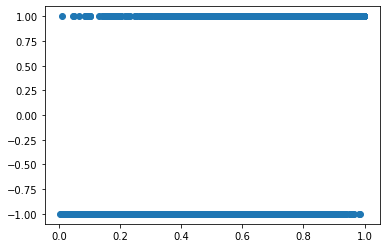

In [50]:
import jax.numpy as jnp
from jax import random, grad, jit, vmap, ops
from functools import partial
import matplotlib.pyplot as plt

@jit
def F(x):
    return 1.0/(1.0 + jnp.exp(-x))

# simulate data
n = 2000
p = 2
tau = 0.01 # precision
# split the key so each object gets its own stream of random numbers
beta_key, covar_key, data_key, rng_key = random.split(random.PRNGKey(0), 4)
true_beta = 1.0 + jnp.arange(p)
X = jnp.column_stack((jnp.ones((n,1,)), random.normal(covar_key, (n,p-1,))))
probs = F(jnp.matmul(X, true_beta))
Y = 2 * random.bernoulli(data_key, p=probs) - 1
plt.scatter(probs,Y) # notice the outliers where probs is high/low but we get a fail/success

In [51]:
@jit
def logprior(beta, tau):
    return -0.5 * tau * jnp.dot(beta, beta)

@jit
def loglike(beta, X, Y):
    return jnp.log(F(Y * jnp.matmul(X, beta)))

@jit 
def logpost(beta, X, Y, tau):
    return logprior(beta, tau) + jnp.sum(loglike(beta, X, Y))

In [52]:
%time logprior(true_beta, tau).block_until_ready()

CPU times: user 44.5 ms, sys: 855 µs, total: 45.4 ms
Wall time: 46.4 ms


DeviceArray(-0.025, dtype=float32)

In [53]:
%time loglike(true_beta, X, Y).block_until_ready()

CPU times: user 102 ms, sys: 0 ns, total: 102 ms
Wall time: 102 ms


DeviceArray([-0.91687495, -0.989686  , -2.4669256 , ..., -0.27701706,
             -0.01429329, -0.07247782], dtype=float32)

In [54]:
%time logpost(true_beta, X, Y, tau).block_until_ready()

CPU times: user 225 ms, sys: 0 ns, total: 225 ms
Wall time: 225 ms


DeviceArray(-883.3722, dtype=float32)

For stochastic gradient descent we need the gradient of the loglikelihood with some subsampled data point...

In [33]:
def gd(rng_key, nits = 1000, learn_rate = 0.05, sample_size = 20):
    beta_key, rng_key = random.split(rng_key)
    beta = random.normal(beta_key, (p,))
    trace_log_post = []
    for _ in range(nits):
        step_key, rng_key = random.split(rng_key, 2)
        i = random.choice(step_key, n, (sample_size,))
        batch_gradients = vmap(partial(grad(logpost), beta, tau=tau))(X[i,], Y[i,])
        beta = beta + learn_rate * n * jnp.mean(batch_gradients, 0)
        trace_log_post.append(logpost(beta, X, Y, tau))
    return beta, trace_log_post

CPU times: user 7.05 s, sys: 564 ms, total: 7.61 s
Wall time: 6.2 s


(DeviceArray([0.75033444, 1.6388698 ], dtype=float32),
 DeviceArray([1., 2.], dtype=float32))

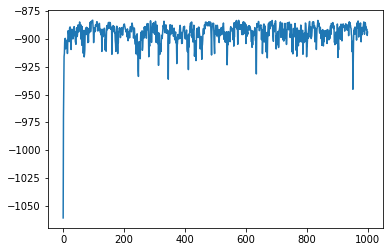

In [42]:
rng_key = random.PRNGKey(0)
%time beta, trace_log_post = gd(rng_key, 1000, 0.001, 50)
plt.plot(trace_log_post)
beta, true_beta

## Improvements

As Jeremy pointed out, the vmap and whole loop body can be pulled out into seperate functions and `jit`ed. Plus there is a cost to splitting the key every iteration that can be saved by generating the batch indices before the loop.

In [98]:
@jit
def part_grad(beta, x, y, tau):
    return vmap(partial(grad(logpost), beta, tau=tau))(x, y)

@jit
def gd_less_keys_inner(beta, batch_index, learn_rate):
    batch_gradients = part_grad(beta, X[batch_index,], Y[batch_index,], tau)
    beta = beta + learn_rate * n * jnp.mean(batch_gradients, 0)
    return beta

In [107]:
def gd_less_keys(rng_key, nits = 1000, learn_rate = 0.05, batch_size = 20, tau=0.01):
    choice_key, beta_key, rng_key = random.split(rng_key, 3)
    beta = random.normal(beta_key, (p,))
    trace_log_post = jnp.zeros(nits)
    batch_indices = random.choice(choice_key, n, (nits, batch_size,))
    for i in range(nits):
        beta = gd_less_keys_inner(beta, batch_indices[i,], learn_rate)
        trace_log_post = trace_log_post.at[i].set(logpost(beta, X, Y, tau))    
    return beta, trace_log_post


jit(gd_less_keys, static_argnums=1)

CPU times: user 2.9 s, sys: 312 ms, total: 3.21 s
Wall time: 2.5 s


(DeviceArray([0.8104567, 1.6174024], dtype=float32),
 DeviceArray([1., 2.], dtype=float32))

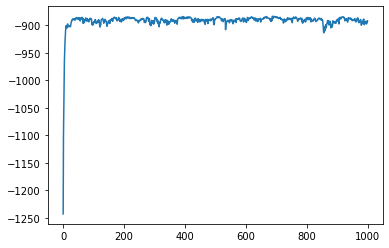

In [108]:
rng_key = random.PRNGKey(0)
%time beta, trace_log_post = gd_less_keys(rng_key, 1000, 0.0005, 50)
plt.plot(trace_log_post)
beta, true_beta